In [93]:
import sys
import os
base_dir = os.path.abspath(".")
sys.path.append(base_dir)

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as PILImage
import cv2


from utils import *
from models.CtRNet import CtRNet



# UR


In [94]:
import argparse
parser = argparse.ArgumentParser()

args = parser.parse_args("")

args.base_dir = "/home/deep/arm_pose_estimation/CTR_UR"
args.use_gpu = True
args.trained_on_multi_gpus = False
args.keypoint_seg_model_path = os.path.join('/home/deep/arm_pose_estimation/outputs/net_best2308.pth') #/home/deep/arm_pose_estimation/CTR_UR/outputs/net_best.pth /home/deep/arm_pose_estimation/outputs/net_best.pth
args.urdf_file = os.path.join("/home/deep/arm_pose_estimation/CTR_UR/ur3e_info/ur3e.urdf")

args.robot_name = 'UR' # "Panda" or "Baxter_left_arm"
args.n_kp = 7
args.height = 720
args.width = 1280
args.fx, args.fy, args.px, args.py = 911.9686279296875, 912.249755859375, 648.4589233398438, 375.2046813964844
args.scale = 0.33 # scale the input image size to (320,240)

# scale the camera parameters
args.width = int(args.width * args.scale)
args.height = int(args.height * args.scale)
args.fx = args.fx * args.scale
args.fy = args.fy * args.scale
args.px = args.px * args.scale
args.py = args.py * args.scale

In [95]:
trans_to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.35563836, 0.34112456, 0.32980388], std=[0.20812908, 0.2141755, 0.2184465]),
])

def preprocess_img(cv_img,args):
    image_pil = PILImage.fromarray(cv_img)
    width, height = image_pil.size
    new_size = (int(width*args.scale),int(height*args.scale))
    image_pil = image_pil.resize(new_size)
    image = trans_to_tensor(image_pil)
    return image

CtRNet = CtRNet(args)

Loading keypoint segmentation model from /home/deep/arm_pose_estimation/outputs/net_best2308.pth
Camera intrinsics: [[300.94964722   0.         213.9914447 ]
 [  0.         301.04241943 123.81754486]
 [  0.           0.           1.        ]]
ERobot: ur3e (by UR), 6 joints (RRRRRR), 3 branches, dynamics, geometry, collision
┌─────┬────────────────┬───────┬────────────────┬─────────────────────────────────────────┐
│link │      link      │ joint │     parent     │           ETS: parent to link           │
├─────┼────────────────┼───────┼────────────────┼─────────────────────────────────────────┤
│   0 │ world          │       │ BASE           │                                         │
│   1 │ base_link      │       │ world          │ SE3()                                   │
│   2 │ shoulder_link  │     0 │ base_link      │ SE3(0, 0, 0.152) ⊕ Rz(q0)               │
│   3 │ upper_arm_link │     1 │ shoulder_link  │ SE3(0, 0.12, 0; 0°, 90°, -0°) ⊕ Ry(q1)  │
│   4 │ forearm_link   │     2

In [96]:
cv_img = cv2.imread('/home/deep/arm_pose_estimation/CTR_UR/realdata/result_test/image/1.png')
cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
image = preprocess_img(cv_img,args)
if args.use_gpu:
    image = image.cuda()

joint_angles = np.array([-0.5574196020709437, 4.766806947975912, -0.2871975898742676, -2.665715833703512, 1.4927363395690918, -0.24131757417787725])

cTr, points_2d, segmentation = CtRNet.inference_single_image(image, joint_angles)
print(CtRNet.cTr_to_pose_matrix(cTr))

tensor([[[-0.6883, -0.5177, -0.5084,  0.4821],
         [ 0.7256, -0.4897, -0.4838,  0.1668],
         [ 0.0014, -0.7018,  0.7132,  0.8205],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0',
       grad_fn=<CopySlices>)


In [97]:
mesh_files = ["/home/deep/arm_pose_estimation/CTR_UR/ur3e_info/base/base.obj",
              "/home/deep/arm_pose_estimation/CTR_UR/ur3e_info/shoulder/shoulder.obj",
              "/home/deep/arm_pose_estimation/CTR_UR/ur3e_info/upperarm/upperarm.obj",
              "/home/deep/arm_pose_estimation/CTR_UR/ur3e_info/forearm/forearm.obj",
              "/home/deep/arm_pose_estimation/CTR_UR/ur3e_info/wrist1/wrist1.obj",
              "/home/deep/arm_pose_estimation/CTR_UR/ur3e_info/wrist2/wrist2.obj",
              "/home/deep/arm_pose_estimation/CTR_UR/ur3e_info/wrist3/wrist3.obj",
             ]

robot_renderer = CtRNet.setup_robot_renderer(mesh_files)
robot_mesh = robot_renderer.get_robot_mesh(joint_angles)
rendered_image = CtRNet.render_single_robot_mask(cTr.squeeze(), robot_mesh, robot_renderer)

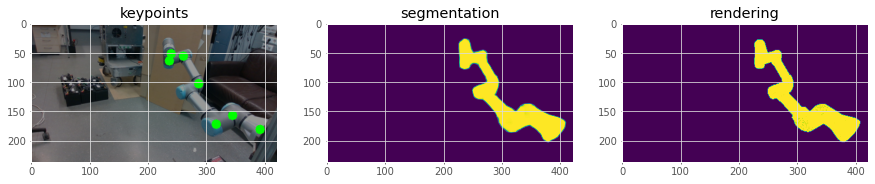

In [98]:
img_np = to_numpy_img(image)
img_np = 0.0* np.ones(img_np.shape) + img_np * 0.6
img_np = overwrite_image(img_np,points_2d.detach().cpu().numpy().squeeze().astype(int), color=(0,1,0))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("keypoints")
plt.imshow(img_np)
plt.subplot(1,3,2)
plt.title("segmentation")
plt.imshow(segmentation.squeeze().detach().cpu().numpy())
plt.subplot(1,3,3)
plt.title("rendering")
plt.imshow(rendered_image.squeeze().detach().cpu().numpy())
plt.show()

# Baxter

In [99]:
import argparse
parser = argparse.ArgumentParser()

args = parser.parse_args("")

args.base_dir = "/home/jingpei/Desktop/CtRNet-robot-pose-estimation"
args.use_gpu = True
args.trained_on_multi_gpus = False
args.keypoint_seg_model_path = os.path.join(args.base_dir,"weights/baxter/net.pth")
args.urdf_file = os.path.join(args.base_dir,"urdfs/Baxter/baxter_description/urdf/baxter.urdf")

args.robot_name = 'Baxter_left_arm' # "Panda" or "Baxter_left_arm"
args.n_kp = 7
args.height = 1536
args.width = 2048
args.fx, args.fy, args.px, args.py = 960.41357421875, 960.22314453125, 1021.7171020507812, 776.2381591796875
args.scale = 0.3125  # scale the input image size to (640,480)

# scale the camera parameters
args.width = int(args.width * args.scale)
args.height = int(args.height * args.scale)
args.fx = args.fx * args.scale
args.fy = args.fy * args.scale
args.px = args.px * args.scale
args.py = args.py * args.scale

In [100]:
trans_to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def preprocess_img(cv_img,args):
    image_pil = PILImage.fromarray(cv_img)
    width, height = image_pil.size
    new_size = (int(width*args.scale),int(height*args.scale))
    image_pil = image_pil.resize(new_size)
    image = trans_to_tensor(image_pil)
    return image

CtRNet = CtRNet(args)

NotImplementedError: 

In [ ]:
cv_img = cv2.imread(os.path.join(args.base_dir,"images/baxter.png"))
cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
image = preprocess_img(cv_img,args)
if args.use_gpu:
    image = image.cuda()


joint_angles = np.array([ 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.8000])

cTr, points_2d, segmentation = CtRNet.inference_single_image(image, joint_angles)
print(CtRNet.cTr_to_pose_matrix(cTr))

tensor([[[ 0.9125,  0.4103,  0.0022, -0.5949],
         [-0.0446,  0.1049, -0.9938,  0.1592],
         [-0.4079,  0.9062,  0.1140,  1.1780],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], device='cuda:0',
       grad_fn=<CopySlices>)


In [ ]:
mesh_files = [os.path.join(args.base_dir,"urdfs/Baxter/S0/S0.obj"), 
              os.path.join(args.base_dir,"urdfs/Baxter/S1/S1.obj"), 
              os.path.join(args.base_dir,"urdfs/Baxter/E0/E0.obj"), 
              os.path.join(args.base_dir,"urdfs/Baxter/E1/E1.obj"), 
              os.path.join(args.base_dir,"urdfs/Baxter/W0/W0.obj"), 
              os.path.join(args.base_dir,"urdfs/Baxter/W1/W1.obj"),
              os.path.join(args.base_dir,"urdfs/Baxter/W2/W2.obj")]

robot_renderer = CtRNet.setup_robot_renderer(mesh_files)
robot_mesh = robot_renderer.get_robot_mesh(joint_angles)
rendered_image = CtRNet.render_single_robot_mask(cTr.squeeze(), robot_mesh, robot_renderer)

/home/jingpei/anaconda3/envs/pytorch_ros/lib/python3.8/site-packages/pytorch3d/transforms/transform3d.py:800: UserWarning: R is not a valid rotation matrix
  warnings.warn(msg)


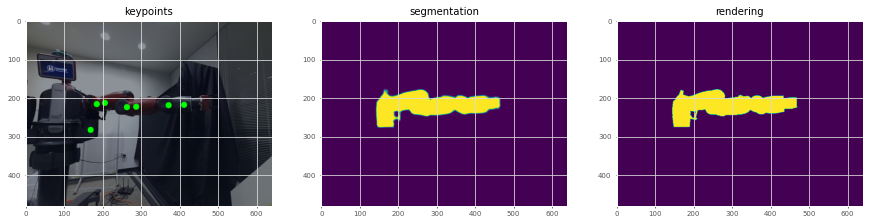

In [ ]:
img_np = to_numpy_img(image)
img_np = 0.0* np.ones(img_np.shape) + img_np * 0.6
img_np = overwrite_image(img_np,points_2d.detach().cpu().numpy().squeeze().astype(int), color=(0,1,0))

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("keypoints")
plt.imshow(img_np)
plt.subplot(1,3,2)
plt.title("segmentation")
plt.imshow(segmentation.squeeze().detach().cpu().numpy())
plt.subplot(1,3,3)
plt.title("rendering")
plt.imshow(rendered_image.squeeze().detach().cpu().numpy())
plt.show()